In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers #type: ignore
#& C:\GalaxyDL\Scripts\Activate.ps1

In [ ]:
# ============================================================
# 1) PARÁMETROS FÍSICOS Y DOMINIO
# ============================================================

g = 9.81  # gravedad m/s^2
Sx = 0.10  # pendiente del cauce (10%)
k_f = 0.2  # fricción efectiva [1/s]

# Dominio espacial (ejemplo 10 km x 2 km)
x_min, x_max = 0.0, 10_000.0   # m
y_min, y_max = -1_000.0, 3_000.0  # m OG -1,1 

# Tiempo total (20 min)
t_min, t_max = 0.0, 1200.0  # s
#OG 1200

# ============================================================
# 2) TOPOGRAFÍA SENCILLA (PLANO INCLINADO)
# ============================================================

def zb(x, y): #Esto es simetrico, como un cono y verter agua arriba
    """
    Topografía del lecho: plano inclinado en x.
    x, y tensores (N,1)
    """
    z0 = 3_000.0  # altura en el inicio del cauce
    return z0 - Sx * x


In [3]:
# ============================================================
# 3) CONDICIÓN INICIAL (PULSO DE LAHAR CERCA DEL VOLCÁN)
# ============================================================

def ic_h(x, y):
    """
    Espesor inicial del lahar: bulto gaussiano en la parte alta.
    """
    x0 = 3000.0  # centro del pulso en x
    y0 = 0.0      # centro en y
    sigma_x = 800.0
    sigma_y = 400.0
    h0_max = 10.0  # m

    return h0_max * tf.exp(-((x - x0)**2 / (2*sigma_x**2) +
                             (y - y0)**2 / (2*sigma_y**2)))

def ic_u(x, y):
    """
    Velocidad inicial en x: puede partir en reposo.
    """
    return tf.zeros_like(x)

def ic_v(x, y):
    """
    Velocidad inicial en y: puede partir en reposo.
    """
    return tf.zeros_like(y)

In [4]:
# ============================================================
# 4) MUESTRA DE PUNTOS DE ENTRENAMIENTO
# ============================================================

N_ic = 5_000     # puntos de condición inicial (t=0)
N_pde = 10_000   # puntos de colación PDE en todo el dominio

# Condición inicial: t = 0
x_ic = tf.random.uniform((N_ic, 1), x_min, x_max, dtype=tf.float32)
y_ic = tf.random.uniform((N_ic, 1), y_min, y_max, dtype=tf.float32)
t_ic = tf.zeros_like(x_ic, dtype=tf.float32)

h_ic_true = ic_h(x_ic, y_ic)
u_ic_true = ic_u(x_ic, y_ic)
v_ic_true = ic_v(x_ic, y_ic)

# Puntos PDE: (x, y, t) en todo el dominio
x_pde = tf.random.uniform((N_pde, 1), x_min, x_max, dtype=tf.float32)
y_pde = tf.random.uniform((N_pde, 1), y_min, y_max, dtype=tf.float32)
t_pde = tf.random.uniform((N_pde, 1), t_min, t_max, dtype=tf.float32)

In [ ]:
# ============================================================
# 5) MODELO PINN CORREGIDO
# ============================================================

# Definimos una capa de normalización personalizada o manual
# Rango de tus datos:
lb = tf.constant([x_min, y_min, t_min], dtype=tf.float32) # Límite inferior
ub = tf.constant([x_max, y_max, t_max], dtype=tf.float32) # Límite superior

def pinn_model():
    # Entrada
    inputs = tf.keras.Input(shape=(3,))

    # 1. Capa de Normalización: Mapea inputs a rango [-1, 1]
    # Fórmula: 2 * (x - lb) / (ub - lb) - 1
    x_norm = 2.0 * (inputs - lb) / (ub - lb) - 1.0

    # 2. Capas Ocultas (Uniformidad y TANH)
    # Tanh es crucial porque tiene segundas derivadas no nulas
    x = layers.Dense(64, activation='tanh')(x_norm)
    x = layers.Dense(64, activation='tanh')(x)
    x = layers.Dense(64, activation='tanh')(x)
    x = layers.Dense(64, activation='tanh')(x)
    x = layers.Dense(64, activation='tanh')(x)

    # 3. Salida
    outputs = layers.Dense(3, activation='linear')(x) #softmax/softplus (Este parece que es mejor)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

model = pinn_model()

# Usamos un learning rate con decaimiento para mejorar convergencia
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = optimizers.Adam(learning_rate=lr_schedule)

In [6]:
# ============================================================
# 6) FUNCIONES AUXILIARES
# ============================================================

@tf.function
def pinn_predict(x, y, t):
    """
    Devuelve h, u, v con forma (N, 1) cada uno.
    """
    inp = tf.concat([x, y, t], axis=1)  # (N,3)
    out = model(inp)
    h = out[:, 0:1]
    u = out[:, 1:2]
    v = out[:, 2:3]
    return h, u, v

@tf.function
def compute_pde_residuals(x, y, t):
    """
    Calcula los residuos de las ecuaciones:
    1) Masa: h_t + (h u)_x + (h v)_y = 0
    2) Mom x: u_t + u u_x + v u_y + g(h+zb)_x + k_f u = 0
    3) Mom y: v_t + u v_x + v v_y + g(h+zb)_y + k_f v = 0
    """

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, y, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, y, t])

            h, u, v = pinn_predict(x, y, t)

            hu = h * u
            hv = h * v

        # Derivadas de primer orden
        h_t = tape1.gradient(h, t)
        h_x = tape1.gradient(h, x)
        h_y = tape1.gradient(h, y)

        u_t = tape1.gradient(u, t)
        u_x = tape1.gradient(u, x)
        u_y = tape1.gradient(u, y)

        v_t = tape1.gradient(v, t)
        v_x = tape1.gradient(v, x)
        v_y = tape1.gradient(v, y)

        hu_x = tape1.gradient(hu, x)
        hv_y = tape1.gradient(hv, y)

    # Topografía y su gradiente
    zb_val = zb(x, y)
    zb_x = tf.constant(-Sx, dtype=tf.float32)  # derivada constante
    zb_x = tf.ones_like(x) * zb_x
    zb_y = tf.zeros_like(y)  # sin variación en y

    # Residuos de las ecuaciones
    # 1) Masa
    f_mass = h_t + hu_x + hv_y

    # 2) Momento en x
    free_surf_x = h_x + zb_x
    f_mom_x = u_t + u * u_x + v * u_y + g * free_surf_x + k_f * u

    # 3) Momento en y
    free_surf_y = h_y + zb_y
    f_mom_y = v_t + u * v_x + v * v_y + g * free_surf_y + k_f * v

    del tape1
    del tape2

    return f_mass, f_mom_x, f_mom_y

In [7]:
# ============================================================
# 7) FUNCIÓN DE PÉRDIDA TOTAL
# ============================================================

mse = tf.keras.losses.MeanSquaredError()

lambda_ic = 10.0   # peso condición inicial; Por que se le da tanto peso a la ic??
lambda_pde = 1.0   # peso ecuaciones físicas

@tf.function
def train_step():
    with tf.GradientTape() as tape:

        # --- Condición inicial ---
        h_ic_pred, u_ic_pred, v_ic_pred = pinn_predict(x_ic, y_ic, t_ic)

        loss_h_ic = mse(h_ic_true, h_ic_pred)
        loss_u_ic = mse(u_ic_true, u_ic_pred)
        loss_v_ic = mse(v_ic_true, v_ic_pred)

        ic_loss = loss_h_ic + loss_u_ic + loss_v_ic

        # --- Pérdida física (PDE) ---
        f_mass, f_mom_x, f_mom_y = compute_pde_residuals(x_pde, y_pde, t_pde)

        loss_mass = tf.reduce_mean(tf.square(f_mass))
        loss_mom_x = tf.reduce_mean(tf.square(f_mom_x))
        loss_mom_y = tf.reduce_mean(tf.square(f_mom_y))

        pde_loss = loss_mass + loss_mom_x + loss_mom_y

        # --- Pérdida total ---
        loss = lambda_ic * ic_loss + lambda_pde * pde_loss

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss, ic_loss, pde_loss, loss_mass, loss_mom_x, loss_mom_y


In [8]:
# ============================================================
# 8) ENTRENAMIENTO
# ============================================================

epochs = 5000  # puedes ajustarlo

for epoch in range(epochs):
    loss, ic_loss, pde_loss, loss_mass, loss_mom_x, loss_mom_y = train_step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Total: {loss.numpy():.4e}, "
              f"IC: {ic_loss.numpy():.4e}, "
              f"PDE: {pde_loss.numpy():.4e}, "
              f"Mass: {loss_mass.numpy():.4e}, "
              f"MomX: {loss_mom_x.numpy():.4e}, "
              f"MomY: {loss_mom_y.numpy():.4e}")

print("Entrenamiento PINN para lahares completado.")

Epoch 100/5000 - Total: 3.9028e+00, IC: 3.0316e-01, PDE: 8.7119e-01, Mass: 5.4118e-06, MomX: 8.7090e-01, MomY: 2.8285e-04
Epoch 200/5000 - Total: 8.7633e-01, IC: 7.0750e-03, PDE: 8.0558e-01, Mass: 1.3538e-05, MomX: 8.0473e-01, MomY: 8.2978e-04
Epoch 300/5000 - Total: 4.2803e-01, IC: 5.1892e-03, PDE: 3.7614e-01, Mass: 1.8424e-05, MomX: 3.7078e-01, MomY: 5.3393e-03
Epoch 400/5000 - Total: 2.1890e-01, IC: 6.1932e-03, PDE: 1.5697e-01, Mass: 2.7704e-05, MomX: 1.5596e-01, MomY: 9.8569e-04
Epoch 500/5000 - Total: 1.9891e-01, IC: 7.3112e-03, PDE: 1.2580e-01, Mass: 3.0628e-05, MomX: 1.2496e-01, MomY: 8.1182e-04
Epoch 600/5000 - Total: 1.3250e-01, IC: 2.5329e-03, PDE: 1.0717e-01, Mass: 3.2838e-05, MomX: 1.0637e-01, MomY: 7.6508e-04
Epoch 700/5000 - Total: 1.2097e-01, IC: 2.1197e-03, PDE: 9.9776e-02, Mass: 3.3666e-05, MomX: 9.9053e-02, MomY: 6.8882e-04
Epoch 800/5000 - Total: 1.0678e-01, IC: 1.7361e-03, PDE: 8.9418e-02, Mass: 3.5756e-05, MomX: 8.8739e-02, MomY: 6.4377e-04
Epoch 900/5000 - Total: 

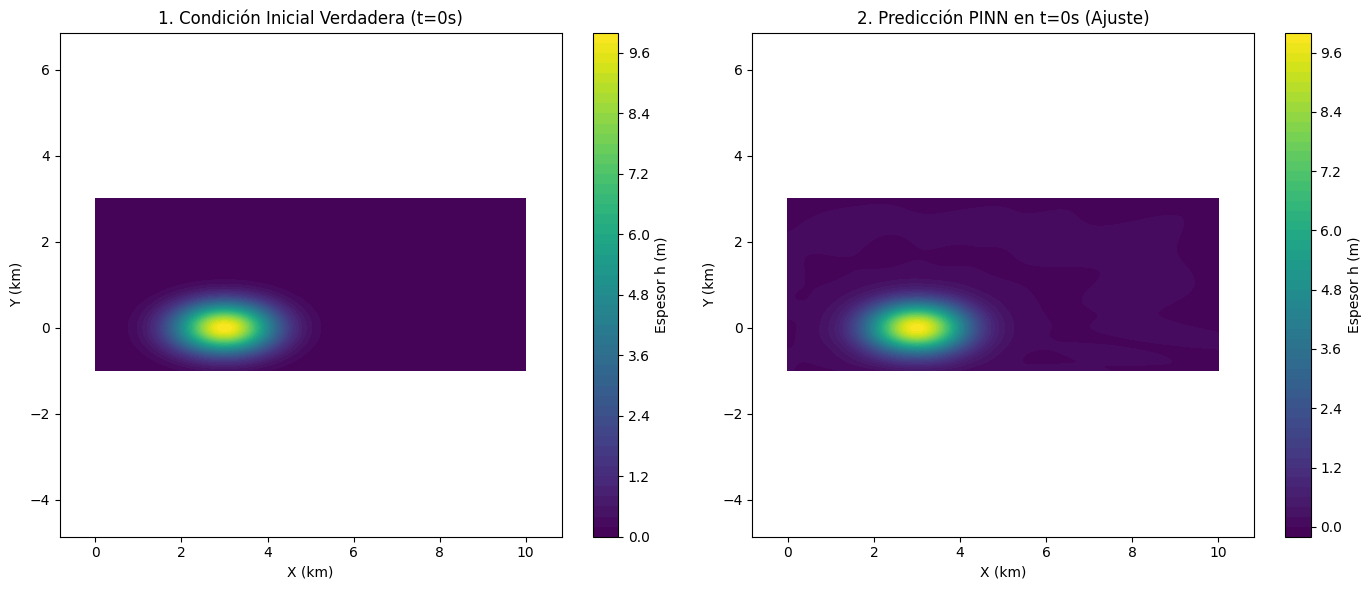

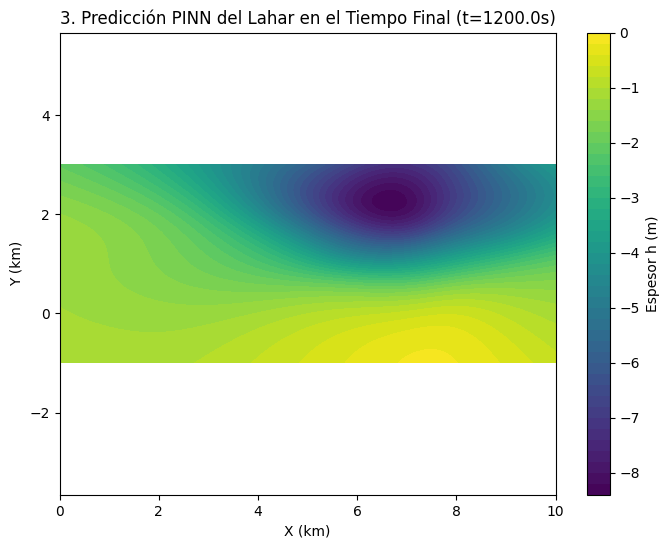

In [ ]:
import matplotlib.pyplot as plt
# ============================================================
# 9) VISUALIZACIÓN DE RESULTADOS
# ============================================================

# 9.1) Generar la malla espacial para la visualización
# Usaremos una rejilla de 200x200 puntos
nx, ny = 200, 200
x_space = np.linspace(x_min, x_max, nx)
y_space = np.linspace(y_min, y_max, ny)
X, Y = np.meshgrid(x_space, y_space)

# 9.2) Predicciones para t = 0 (Condición Inicial)
t_ic_plot = t_min  # t=0
T_IC = np.ones_like(X) * t_ic_plot

# Aplanar la malla para alimentar al modelo (X, Y, T_IC) -> (N, 3)
x_flat_ic = X.flatten().reshape(-1, 1)
y_flat_ic = Y.flatten().reshape(-1, 1)
t_flat_ic = T_IC.flatten().reshape(-1, 1)

# Función de predicción del PINN para la malla
h_pred_ic, _, _ = pinn_predict(tf.constant(x_flat_ic, dtype=tf.float32),
                                tf.constant(y_flat_ic, dtype=tf.float32),
                                tf.constant(t_flat_ic, dtype=tf.float32))

# Redimensionar a la malla original (200, 200)
h_ic_pred_grid = h_pred_ic.numpy().reshape(X.shape)

# 9.3) Predicciones para t = t_max (Resultado final)
t_final_plot = t_max # t=1200s
T_FINAL = np.ones_like(X) * t_final_plot

# Aplanar la malla para alimentar al modelo (X, Y, T_FINAL) -> (N, 3)
x_flat_final = X.flatten().reshape(-1, 1)
y_flat_final = Y.flatten().reshape(-1, 1)
t_flat_final = T_FINAL.flatten().reshape(-1, 1)

# Función de predicción del PINN para la malla
h_pred_final, _, _ = pinn_predict(tf.constant(x_flat_final, dtype=tf.float32),
                                tf.constant(y_flat_final, dtype=tf.float32),
                                tf.constant(t_flat_final, dtype=tf.float32))

# Redimensionar a la malla original (200, 200)
h_final_pred_grid = h_pred_final.numpy().reshape(X.shape)

# 9.4) Cálculo de la Condición Inicial "Verdadera" para la malla
# Esto sirve como el "target" de comparación en t=0
h_ic_true_grid = ic_h(tf.constant(x_flat_ic, dtype=tf.float32), 
                      tf.constant(y_flat_ic, dtype=tf.float32)).numpy().reshape(X.shape)


# -------------------------------------------------------------
# GRÁFICOS SOLICITADOS
# -------------------------------------------------------------

# Gráfico 1: Comparación (IC Verdadero vs. PINN Predicción en t=0)
plt.figure(figsize=(14, 6))

# Subplot 1: Condición Inicial (Verdadera)
plt.subplot(1, 2, 1)
cf1 = plt.contourf(X / 1000, Y / 1000, h_ic_true_grid, levels=50, cmap='viridis',vmin=0,vmax=10)
plt.colorbar(cf1, label='Espesor h (m)')
plt.title('1. Condición Inicial Verdadera (t=0s)')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.axis('equal')

# Subplot 2: Predicción PINN en t=0s
plt.subplot(1, 2, 2)
cf2 = plt.contourf(X / 1000, Y / 1000, h_ic_pred_grid, levels=50, cmap='viridis',vmin=0,vmax=10)
plt.colorbar(cf2, label='Espesor h (m)')
plt.title('2. Predicción PINN en t=0s (Ajuste)')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.axis('equal')

plt.tight_layout()
plt.show()

# Gráfico 2: Predicción PINN en el tiempo final (Resultado del Flujo)
plt.figure(figsize=(8, 6))
cf3 = plt.contourf(X / 1000, Y / 1000, h_final_pred_grid, levels=50, cmap='viridis')
plt.colorbar(cf3, label='Espesor h (m)')
plt.title(f'3. Predicción PINN del Lahar en el Tiempo Final (t={t_max}s)')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.axis('equal')
plt.show()

## Ver que el color map sus limites sean iguales
## Quitar parte blanca del plot
## Ver que no se abultone en los bordes. Considerar densidad, dom espacial y tiempo
## Estudiar las eq de movimiento
## Como se puede hacer esto mas realista?
## Guardar el modelo

# Ideas
- Plano inclinado 2D con ruido
- SERNAGEOMIN: Buscar mapas de lahares del sur de Chile donde se ramifique
- Espesor vs distancia